In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numba
import pickle
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)

def fig_panel_labels(axes, letters='ABCDEFGHIJKLMNOP', xcoord=-0.17, ycoord=0.92, panel_label_size=plt.rcParams[ 'axes.titlesize']*1.3):
    return [
        ax.annotate(letter, (xcoord, ycoord), xycoords='axes fraction', fontsize=panel_label_size)
        for ax, letter 
        in zip(axes.flat, letters)
    ]

# Modifier model

| pheno-genotype     | mA  | mB     | MA  | MB     |
|------|-----|--------|-----|--------|
| frequency    | $x_1$  | $x_2$ | $x_3$  | $x_4$ |
| fitness    | $\omega_A$ | $\omega_B$    | $\omega_A$ | $\omega_B$    |
| vertical transmission rate | $\rho$   | $\rho$      | $P$   | $P$      |


The population recurrence is 

$$
\bar{\omega} x_1' = x_1 \omega_A ((1-\rho)(x_1 + x_3)+\rho) + x_2 \omega_B(1-\rho)(x_1 + x_3) \\
\bar{\omega} x_2' = x_1 \omega_A (1-\rho)(x_2 + x_4) + x_2 \omega_B ((1-\rho)(x_2 + x_4) + \rho) \\
\bar{\omega} x_3' = x_3 \omega_A ((1-P)(x_1 + x_3) + P) + x_4 \omega_B (1-P)(x_1 + x_3) \\
\bar{\omega} x_4' = x_3 \omega_A (1-P)(x_2 + x_4) + x_4 \omega_B ((1-P)(x_2 + x_4) + P) \\
\bar{\omega} = \omega_A (x_1 + x_3) + \omega_B (x_2 + x_4)
$$

# Modifier numerical simulation

In [2]:
@numba.jit()
def recursion(x, wA, wB, ρ, P, N=0):
    x1, x2, x3, x4 = x
    x1_ = x1 * wA * ((1 - ρ) * (x1 + x3) + ρ) + x2 * wB * (1 - ρ) * (x1 + x3)
    x2_ = x1 * wA * (1 - ρ) * (x2 + x4) + x2 * wB * ((1 - ρ) * (x2 + x4) + ρ)
    x3_ = x3 * wA * ((1 - P) * (x1 + x3) + P) + x4 * wB * (1 - P) * (x1 + x3)
    x4_ = x3 * wA * (1 - P) * (x2 + x4) + x4 * wB * ((1 - P) * (x2 + x4) + P)
    x = x1_, x2_, x3_, x4_
    x = np.array(x)
    x /= x.sum()
    if N > 0:
        x = np.random.multinomial(N, x) / N
    return x

recursion((0.4,0.4,0.1,0.1), 1.1, 1, 0.1, 0, 1e6)

array([ 0.401155,  0.39862 ,  0.100291,  0.099934])

In [3]:
@numba.jit()
def evolution(ρ0=0.1, W = 1, w = 0.1, m0 = 0.999, A0 = 0.1, n = 10000000, N = 0, envch_rate=0):
    N = int(N)
    ρ = ρ0
    P = ρ/10
    W_, w_ = w, W
    x = np.zeros((4, n))
    x[:, 0] = [m0*A0, m0*(1-A0), (1-m0)*A0, (1-m0)*(1-A0)]
    rate = np.array([0.0]*n)
    rate[0] = ρ * (x[0,0] + x[1,0]) + P * (x[2,0] + x[3,0])
    invasions = []

    for t in range(1, n):
        if envch_rate == 0:
            W_, w_ = w_, W_
        elif np.random.random() < envch_rate:
            W_, w_ = W, w
        else:
            W_, w_ = w, W

        x[:, t] = recursion(
            x[:, t-1], W_, w_, ρ, P, N
        )
        rate[t] = ρ * (x[0,t] + x[1,t]) + P * (x[2,t] + x[3,t])
        if x[0,t] + x[1,t] > 0.999:
            if x[0,t] > x[1,t]:
                x[0,t] -= 0.0001
                x[2,t] += 0.0001
            else:
                x[1,t] -= 0.0001
                x[3,t] += 0.0001        
        if x[0,t] + x[1,t] < 0.0001:
            x[0,t], x[1,t], x[2,t], x[3,t] = x[2,t], x[3,t], x[0,t], x[1,t]
            print(P, end=' ')
            ρ, P = P, P/10        
            invasions.append(t)
    return x, invasions, rate

In [53]:
def plot_invasions(x, invasions, rate, ρ0, time_step=1, filename=None):
    fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharey=False, sharex=True)
    axes[0].plot(
        np.arange(0, x.shape[1], time_step),
        x[0,::time_step] + x[2,::time_step], 
        label='A'
    )
    # axes[0].axhline(e, ls='--', color='gray')
    axes[2].plot(
        np.arange(0, rate.shape[0], time_step),
        rate[::time_step]
    )
    t = 0
    for i, inv in enumerate(invasions):
        for j in range(3): axes[j].axvline(inv, ls='--', lw=1, color='gray')
        axes[1].plot(
            np.arange(t, inv, time_step),
            x[2,t:inv:time_step] + x[3,t:inv:time_step], 
            label='{:.2g}'.format(ρ0/(10**(i+1)))
        )
        t = inv
    axes[0].set(ylim=(0,1), ylabel='Frequency of phenotype $A$')
#     axes[0].legend()
    axes[1].set(ylim=(0,1), ylabel='Invader frequency')
    axes[1].legend(title='Rate')
    axes[2].set(ylabel='Mean vertical transmission rate', yscale='log', xlabel='Time', xscale='log', ylim=(rate.min(), rate.max()))

    labels = fig_panel_labels(axes, xcoord=-0.18, ycoord=1.0)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', bbox_extra_artists=labels)
    return fig, axes

In [ ]:
x, invasions, rate = evolution(ρ0=0.1, n=1000000, envch_rate=0, N=0)
with open('A1B1_modifier_invasions.pkl', 'wb') as f:
    pickle.dump(
        dict(x=x, invasions=invasions, rate=rate),
        f
)

0.01 0.001 0.0001 1e-05 

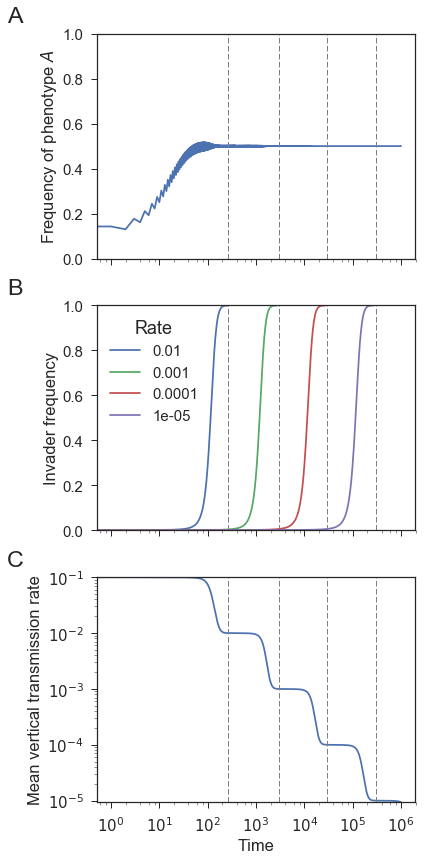

In [10]:
with open('A1B1_modifier_invasions.pkl', 'rb') as f:
    d = pickle.load(f)
x = d['x']
invasions = d['invasions']
rate = d['rate']
del d

fig, axes = plot_invasions(x, invasions, rate, ρ0=0.1, filename='../figures/A1B1_modifier_invasions.pdf')

In [5]:
x, invasions, rate = evolution(ρ0=0.45, n=100000000, envch_rate=0.5, N=0)

0.045 0.0045 0.00045 

In [55]:
np.savez_compressed('stoch_modifier_invasions.npz', x=x, invasions=invasions, rate=rate)

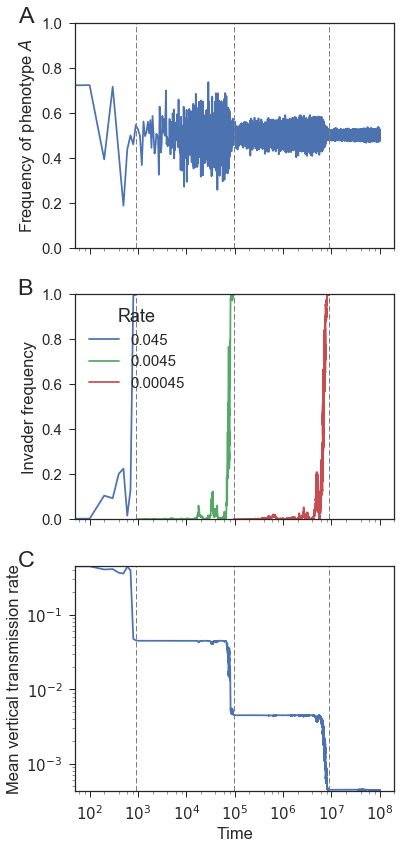

In [54]:
fig, axes = plot_invasions(x, invasions, rate, ρ0=0.45, time_step=100, filename='../figures/stoch_modifier_invasions.pdf')

# Modifier analysis

In [39]:
import sympy
sympy.init_printing()

In [40]:
x, s, ρ, P = sympy.symbols('x s ρ P', real=True, positive=True)

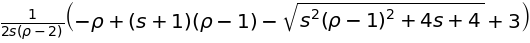

In [41]:
x_star = ((1 + s) * (1 - ρ) - (3 - ρ) + sympy.sqrt((1 - ρ)**2 * s**2 + 4 * (1 + s))) / (2 * (2 -  ρ) * s)
x_star = sympy.simplify(x_star)
x_star

In [43]:
x_star_prime = x_star * (x_star * (1 - ρ) * s + ρ * (1 + s) + (1 - ρ)) / (1 + s * x_star)
x_star_prime = 1 - x_star

In [15]:
x_star_eta_0 = 1/(4*s) * (s + (s+2) -2)
x_star_eta_0

In [16]:
x_star = x_star_eta_0

In [70]:
# Mean fitness

s_ = np.linspace(0, 2, 100)
ρ_ = np.linspace(0, 1, 100).reshape(100, 1)

ww = (s_ * (1 - ρ_) - 2 + np.sqrt((1 - ρ_)**2 * s_**2 + 4*(1 + s_))) / (2 * (2 - ρ_))

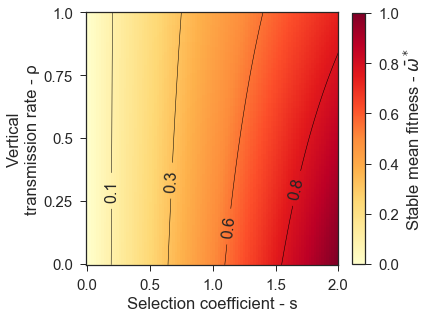

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

ax = axes#[0]
extent = (-0.5, ww.shape[0], -0.5, ww.shape[1])
im = ax.imshow(ww, cmap='YlOrRd', origin=(0,0), aspect=1, extent=extent, interpolation='none')
cntr = ax.contour(ww, levels=np.linspace(0.1, 1, 5), aspect=1, linewidths=0.5, colors='k', extent=extent)
ax.clabel(cntr, fmt=lambda x: '{:.1f}'.format(x), fontsize=16, colors="#252525")
cb1 = plt.colorbar(im, ax=ax, fraction=0.045, label=r'Stable mean fitness - $\bar{\omega}^*$')
ax.set_xlabel('Selection coefficient - s')
ylabel1 = ax.set_ylabel('Vertical\ntransmission rate - ρ')
ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels(np.linspace(0, 2, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5))

fig.savefig('../figures/A1B1_mean_fitness.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)

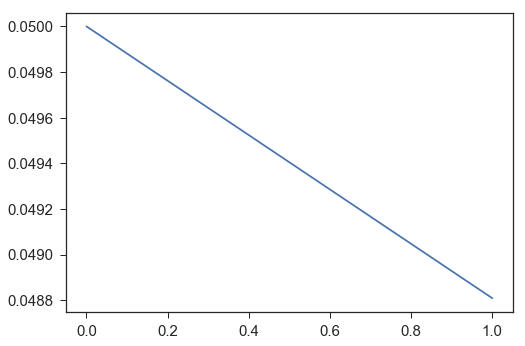

In [57]:
s_ = 0.1
ww = [
    (s_ * (1 - ρ_) - 2 + np.sqrt((1 - ρ_)**2 * s_**2 + 4*(1 + s_))) / (2 * (2 - ρ_))
    for ρ_ in np.linspace(0,1)
]
plt.plot(np.linspace(0,1), ww)